## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
from fastai_extensions import *

In [3]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [4]:
data_dir = Path('data')
data_04 = Path('data_04')

In [5]:
MODEL_NAME='bg_const'

In [6]:
NB_NUM='03_28'

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 540277ad, DATE: 20191201


In [8]:
DATE = '20191201'
UID = '0c79e3be'

In [9]:
SUB_NUM='30'

In [10]:
img_size=256
bs=128
background='constant'

In [11]:
train_images=data_04/f'train/rotated/clipped/constant/{img_size}'
test_images=data_04/f'test/rotated/clipped/constant/{img_size}'

In [12]:
train_names = get_image_files(train_images)

In [13]:
test_names = get_image_files(test_images)

### using valid + gold preds instead of all

In [14]:
df_gold=pd.read_csv(data_dir/'df_all_repl_st_lucia_castries_gold_concrete_cement.csv')

In [15]:
df_gold.drop(columns=['target'],inplace=True)

In [16]:
df_gold=df_gold[['id','roof_material','verified','country','region']]

In [17]:
df_gold.tail()

,id,roof_material,verified,country,region
22534,7a3585be,concrete_cement,True,st_lucia,castries
22535,7a1d3324,concrete_cement,True,st_lucia,castries
22536,7a30849c,concrete_cement,True,st_lucia,castries
22537,7a27186c,concrete_cement,True,st_lucia,castries
22538,7a34ef78,concrete_cement,True,st_lucia,castries


In [18]:
df_pewter_70pct=pd.read_csv(data_dir/'st_lucia_castries_gros_islet_70pct_rn50-rn152-dn121_preds.csv')

In [19]:
df_pewter_70pct.tail()

,id,roof_material,verified,country,region
3364,7a3a5eea,other,True,st_lucia,gros_islet
3365,7a3b3dce,other,True,st_lucia,castries
3366,7a3cfda8,other,True,st_lucia,gros_islet
3367,7a42d1a6,other,True,st_lucia,gros_islet
3368,7a4494c8,other,True,st_lucia,gros_islet


In [20]:
frames = [df_gold, df_pewter_70pct]

df_gold_pewter = pd.concat(frames)

In [21]:
#### test data

In [22]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [23]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [24]:
assert len(df_test)==7325

In [25]:
gp_ids=df_gold_pewter.id.values.tolist()

In [26]:
train_names[0:10]

[PosixPath('data_04/train/rotated/clipped/constant/256/7a2726ae_256_reflect.tif'),
 PosixPath('data_04/train/rotated/clipped/constant/256/7a1fa6f4_256_bgconstant.tif'),
 PosixPath('data_04/train/rotated/clipped/constant/256/7a37f9b6_zoom.tif'),
 PosixPath('data_04/train/rotated/clipped/constant/256/7a1d17fe_256_reflect.tif'),
 PosixPath('data_04/train/rotated/clipped/constant/256/7a29b036_256_wrap.tif'),
 PosixPath('data_04/train/rotated/clipped/constant/256/7a3e757a_256_wrap.tif'),
 PosixPath('data_04/train/rotated/clipped/constant/256/7a3bd810_256_wrap.tif'),
 PosixPath('data_04/train/rotated/clipped/constant/256/7a2f73ea_256_reflect.tif'),
 PosixPath('data_04/train/rotated/clipped/constant/256/7a2e1658_256_wrap.tif'),
 PosixPath('data_04/train/rotated/clipped/constant/256/7a208484_raw.tif')]

In [27]:
trn_file_names=[]
for f in train_names:
    trn_file_names.append(f.name.split('.tif')[0])

In [28]:
trn_file_names[0:10]

['7a2726ae_256_reflect',
 '7a1fa6f4_256_bgconstant',
 '7a37f9b6_zoom',
 '7a1d17fe_256_reflect',
 '7a29b036_256_wrap',
 '7a3e757a_256_wrap',
 '7a3bd810_256_wrap',
 '7a2f73ea_256_reflect',
 '7a2e1658_256_wrap',
 '7a208484_raw']

In [29]:
bg_const_names=[]
for f in trn_file_names:
    if '_256_bgconstant' in f:
        bg_const_names.append(f.split('_256_bgconstant')[0])
        
raw_names=[]
for f in trn_file_names:
    if '_raw' in f:
        raw_names.append(f.split('_raw')[0])
        
zoom_names=[]
for f in trn_file_names:
    if '_zoom' in f:
        zoom_names.append(f.split('_zoom')[0])
        
reflect_names=[]
for f in trn_file_names:
    if '_256_reflect' in f:
        reflect_names.append(f.split('_256_reflect')[0])
        
wrap_names=[]
for f in trn_file_names:
    if '_256_wrap' in f:
        wrap_names.append(f.split('_256_wrap')[0])


In [30]:
df_gold_pewter_bg_const=df_gold_pewter.loc[df_gold_pewter['id'].isin(bg_const_names)]

In [31]:
df_gold_pewter_bg_const['id']=df_gold_pewter_bg_const['id']+'_256_bgconstant'

In [32]:
df_gold_pewter_bg_const.head()

,id,roof_material,verified,country,region
0,7a3f2a10_256_bgconstant,concrete_cement,True,colombia,borde_rural
1,7a1f731e_256_bgconstant,irregular_metal,True,colombia,borde_rural
2,7a424ad8_256_bgconstant,healthy_metal,True,colombia,borde_rural
3,7a3edc5e_256_bgconstant,healthy_metal,True,colombia,borde_rural
4,7a303a6e_256_bgconstant,healthy_metal,True,colombia,borde_rural


In [33]:
df_gold_pewter_bg_const=df_gold_pewter_bg_const.drop_duplicates(subset=['id'])

Ensure is only ids with _256_bgconstant

In [34]:
len(bg_const_names)

22553

In [35]:
#### raw

In [36]:
len(raw_names)

22553

In [37]:
df_gold_pewter_raw=df_gold_pewter.loc[df_gold_pewter['id'].isin(raw_names)]

In [38]:
df_gold_pewter_raw['id']=df_gold_pewter_raw['id']+'_raw'

In [39]:
df_gold_pewter_raw.head()

,id,roof_material,verified,country,region
0,7a3f2a10_raw,concrete_cement,True,colombia,borde_rural
1,7a1f731e_raw,irregular_metal,True,colombia,borde_rural
2,7a424ad8_raw,healthy_metal,True,colombia,borde_rural
3,7a3edc5e_raw,healthy_metal,True,colombia,borde_rural
4,7a303a6e_raw,healthy_metal,True,colombia,borde_rural


In [40]:
len(df_gold_pewter_raw)

25908

In [41]:
df_gold_pewter_raw=df_gold_pewter_raw.drop_duplicates(subset=['id'])

In [42]:
#### zoom

In [43]:
len(zoom_names)

2234

In [44]:
df_gold_pewter_zoom=df_gold_pewter.loc[df_gold_pewter['id'].isin(zoom_names)]

In [45]:
df_gold_pewter_zoom['id']=df_gold_pewter_zoom['id']+'_zoom'

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
df_gold_pewter_zoom.head()

,id,roof_material,verified,country,region
64,7a42454c_zoom,concrete_cement,True,colombia,borde_rural
72,7a407a64_zoom,irregular_metal,True,colombia,borde_rural
73,7a41a984_zoom,irregular_metal,True,colombia,borde_rural
94,7a320e20_zoom,irregular_metal,True,colombia,borde_rural
184,7a34bb84_zoom,irregular_metal,True,colombia,borde_rural


In [47]:
len(df_gold_pewter_zoom)

2632

In [48]:
df_gold_pewter_zoom=df_gold_pewter_zoom.drop_duplicates(subset=['id'])

In [49]:
len(df_gold_pewter_zoom)

2232

In [50]:
#### wrap

In [51]:
len(wrap_names)

22553

In [52]:
df_gold_pewter_wrap=df_gold_pewter.loc[df_gold_pewter['id'].isin(wrap_names)]

In [53]:
df_gold_pewter_wrap['id']=df_gold_pewter_wrap['id']+'_256_wrap'

In [54]:
df_gold_pewter_wrap.head()

,id,roof_material,verified,country,region
0,7a3f2a10_256_wrap,concrete_cement,True,colombia,borde_rural
1,7a1f731e_256_wrap,irregular_metal,True,colombia,borde_rural
2,7a424ad8_256_wrap,healthy_metal,True,colombia,borde_rural
3,7a3edc5e_256_wrap,healthy_metal,True,colombia,borde_rural
4,7a303a6e_256_wrap,healthy_metal,True,colombia,borde_rural


In [55]:
len(df_gold_pewter_wrap)

25908

In [56]:
df_gold_pewter_wrap=df_gold_pewter_wrap.drop_duplicates(subset=['id'])

In [57]:
#### reflect

In [58]:
len(reflect_names)

22553

In [59]:
df_gold_pewter_reflect=df_gold_pewter.loc[df_gold_pewter['id'].isin(reflect_names)]

In [60]:
df_gold_pewter_reflect['id']=df_gold_pewter_reflect['id']+'_256_reflect'

In [61]:
df_gold_pewter_reflect.head()

,id,roof_material,verified,country,region
0,7a3f2a10_256_reflect,concrete_cement,True,colombia,borde_rural
1,7a1f731e_256_reflect,irregular_metal,True,colombia,borde_rural
2,7a424ad8_256_reflect,healthy_metal,True,colombia,borde_rural
3,7a3edc5e_256_reflect,healthy_metal,True,colombia,borde_rural
4,7a303a6e_256_reflect,healthy_metal,True,colombia,borde_rural


In [62]:
len(df_gold_pewter_reflect)

25908

In [63]:
df_gold_pewter_reflect=df_gold_pewter_reflect.drop_duplicates(subset=['id'])

append them all

In [64]:
frames = [df_gold_pewter_bg_const, df_gold_pewter_reflect, df_gold_pewter_wrap, df_gold_pewter_zoom]

df_gold_pewter = pd.concat(frames)

In [65]:
len(df_gold_pewter)

69849

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [66]:
kwargs = {
    'size': .3,            # range(0.-1.) You can indicate the size of the patched area/s
    'alpha': 1.,           # This is used to define a proba distribution
    'fixed_proba': 0,      # This overrides alpha proba distribution. Will fix the % of the image that is modified
    'grid': True,          # Determine if patches may overlap or not. With True they do not overlap
    'blend_type': 'zero',   # Options: 'zero', 'noise', 'mix', 'cut', 'random'
    'same_size': False,     # All patches may have the same size or not
    'same_crop': False,    # Cropping patches are from the same subregion as input patches (only with 'mix' and 'cut')
    'same_image': False,   # Cropping patches will be from the same or different images (only with 'mix' and 'cut')
}
#learn = Learner(data,models.resnet34()).blend(**kwargs).show_tfms()

In [67]:
cutout_1=cutout(n_holes=(1,4), length=(10, 20), p=.5)
cutout_2=cutout(n_holes=(1,4), length=(20, 30), p=.5)
cutout_3=cutout(n_holes=(1,4), length=(20,20), p=.6)
cutout_4=cutout(n_holes=(1,4), length=(40,40), p=.6)
xtra_tfms=[cutout_1,cutout_2,cutout_3,cutout_4, rand_crop(p=0.4), rand_zoom(scale=(1.,1.5),p=0.4)]
tfms = get_transforms(flip_vert=True, max_lighting=0.25, max_warp=0., xtra_tfms=xtra_tfms)

### setup dataset

In [68]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_gold_pewter, cols='id', suffix='.tif')
       .split_by_rand_pct(0.1)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

69849


In [69]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [70]:
#to check what params object has
#dir(data)

In [71]:
data.label_list

LabelLists;

Train: LabelList (62865 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_04/train/rotated/clipped/constant/256;

Valid: LabelList (6984 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,healthy_metal,healthy_metal,irregular_metal
Path: data_04/train/rotated/clipped/constant/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_04/train/rotated/clipped/constant/256

In [72]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

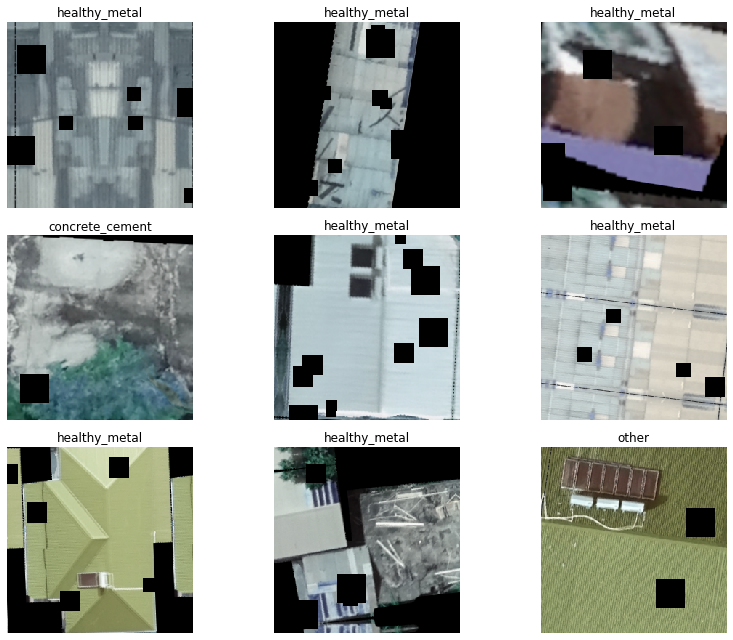

In [73]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [74]:
arch = models.resnet50
arch_name = 'rn50'

In [75]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

We use the LR Finder to pick a good learning rate.

### Train model

In [76]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


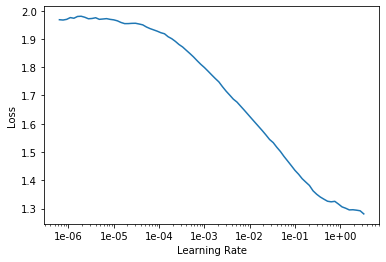

In [77]:
learn.recorder.plot()

Then we can fit the head of our network.

In [78]:
lr = 1e-2

In [79]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.543244,0.461856,0.152635,02:44
1,0.393876,0.371251,0.134450,02:42
2,0.363529,0.322255,0.115693,02:43
3,0.345179,0.308844,0.113259,02:42
4,0.337356,0.301524,0.108534,02:43


<pre>
03_1 results

epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.508273 	1.170024 	0.339911 	01:16
1 	0.471699 	0.494651 	0.166297 	01:22
2 	0.439157 	0.417086 	0.152328 	01:23
3 	0.402381 	0.370002 	0.127938 	01:23
4 	0.355355 	0.360440 	0.126608 	01:22
    </pre>

In [80]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')


#### Load model

In [81]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (62865 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_04/train/rotated/clipped/constant/256;

Valid: LabelList (6984 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,healthy_metal,healthy_metal,irregular_metal
Path: data_04/train/rotated/clipped/constant/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_04/train/rotated/clipped/constant/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1,

In [82]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 308),
 ('healthy_metal', 'irregular_metal', 140),
 ('incomplete', 'irregular_metal', 78),
 ('concrete_cement', 'healthy_metal', 42),
 ('other', 'healthy_metal', 38),
 ('healthy_metal', 'concrete_cement', 34),
 ('incomplete', 'concrete_cement', 32),
 ('irregular_metal', 'concrete_cement', 21),
 ('concrete_cement', 'irregular_metal', 16),
 ('incomplete', 'healthy_metal', 15),
 ('other', 'irregular_metal', 13),
 ('irregular_metal', 'incomplete', 6),
 ('concrete_cement', 'incomplete', 4),
 ('irregular_metal', 'other', 4),
 ('healthy_metal', 'incomplete', 2),
 ('healthy_metal', 'other', 2),
 ('other', 'concrete_cement', 2)]

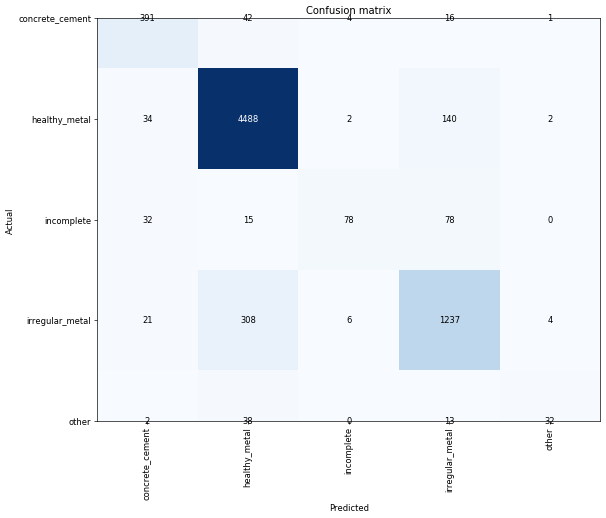

In [83]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [84]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


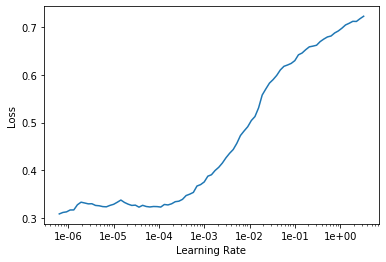

In [85]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.327387,0.308223,0.112257,03:22
1,0.325737,0.285384,0.102663,03:21


In [ ]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [47]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (20727 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (5181 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,healthy_metal,healthy_metal,irregular_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4

In [48]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.347066,0.355291,0.130284,01:14
1,0.349023,0.352312,0.127389,01:14
2,0.320178,0.331796,0.116387,01:09
3,0.302266,0.315345,0.115422,01:14
4,0.274667,0.293486,0.107508,01:14


<pre>
03_1

 epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.344736 	0.349004 	0.125277 	01:27
1 	0.343708 	0.355190 	0.129047 	01:15
2 	0.351904 	0.371296 	0.131042 	01:14
3 	0.346994 	0.346989 	0.123947 	01:14
4 	0.323809 	0.346372 	0.126608 	01:15
</pre>

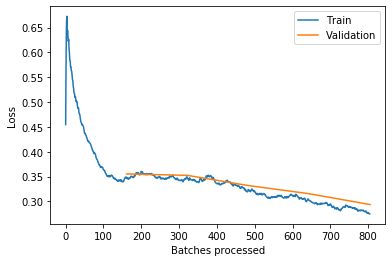

In [49]:
learn.recorder.plot_losses()

In [50]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [51]:
learn=learn.to_fp32()

In [52]:
learn.export(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

### inference

In [53]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [54]:
len(test_dataset)

15325

In [55]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [56]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [57]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [58]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [59]:
len(learn.dl(DatasetType.Test))

240

Get number of items in the Valid dataset (in DeviceDataLoader)

In [60]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [61]:
labels = np.argmax(preds, 1)

In [62]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [63]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [64]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [65]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [66]:
test_predictions[0]

'healthy_metal'

In [67]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [68]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a468774.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4b7946.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4e81f4.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a501f50.tif')], dtype=object)

In [69]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [70]:
preds_list[0]

[0.026818877086043358,
 0.9646494388580322,
 0.0015079181175678968,
 0.006024457979947329,
 0.0009992941049858928]

In [71]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [72]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [73]:
pred_df.insert(loc=0, column='id', value=ids)

In [74]:
pred_df.columns = cols

In [75]:
pred_ids=pred_df['id'].values.tolist()

In [76]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [77]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [78]:
baseline_ids=df_baseline['id'].values.tolist()

In [79]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [80]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [81]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.026819,0.964649,0.001508,0.006024,0.000999,7a4d9168
1,7a4ae922,0.004032,0.926549,0.001440,0.066405,0.001574,7a4ae922
2,7a48ca98,0.002101,0.252532,0.007539,0.737148,0.000680,7a48ca98
3,7a49c614,0.001265,0.685554,0.001319,0.311066,0.000796,7a49c614
4,7a4dd4f2,0.000448,0.929096,0.001460,0.063948,0.005048,7a4dd4f2


In [82]:
pred_df=pred_df.sort_values('id_cat')

In [83]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
8041,7a4d630a,0.003314,0.990373,0.000842,0.004528,0.000943,7a4d630a
716,7a4d630a,0.003314,0.990373,0.000842,0.004528,0.000943,7a4d630a
764,7a4bbbd6,0.002045,0.952722,0.000728,0.043938,0.000567,7a4bbbd6
8089,7a4bbbd6,0.002045,0.952722,0.000728,0.043938,0.000567,7a4bbbd6
1841,7a4ac744,0.002437,0.591260,0.013695,0.390772,0.001837,7a4ac744


In [84]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [91]:
pred_df.head()

,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,0.003314,0.990373,0.000842,0.004528,0.000943
1,0.003314,0.990373,0.000842,0.004528,0.000943
2,0.002045,0.952722,0.000728,0.043938,0.000567
3,0.002045,0.952722,0.000728,0.043938,0.000567
4,0.002437,0.591260,0.013695,0.390772,0.001837


In [93]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [94]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

### Submission 35: 0.4642


In [92]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

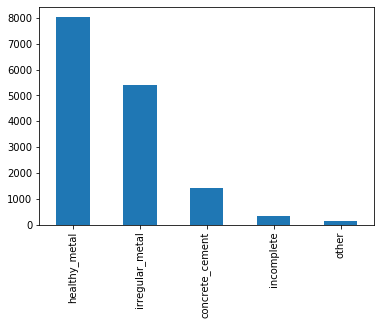

In [88]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")